Lab01-2
======

### Context
#### Clustering
+ Hierarchical Clustering



# Hierarchical Clustering
### 특징
Hierarchical Clustering은 거리(Distance) 또는 유사도(Similarity)를 기반으로 클러스터를 형성하는 알고리즘 입니다.<br> 
k-means Clustering과 다르게 클러스터의 수를 설정해 줄 필요가 없으며, 클러스터 형태를 시각적으로 표현해주는 덴드로그램을 통해 적절한 클러스터의 수를 선택할 수 있습니다.<br>
Hierachichal Clustering에는 Bottom-Up 방식의 Agglomerative Method와 Top-Down 방식의 Divisive Method로 나뉩니다.<br>
이번 단원에서는 Agglomerative Method를 사용해 실습을 진행합니다.
<br><br>Agglomerative Method를 사용한 Hierarchical Clustering 알고리즘은 3가지 단계로 이루어집니다.<br>
Step 1. 각 데이터 포인트를 클러스터로 할당합니다. (n개의 클러스터)<br>
Step 2. 가까운 클러스터끼리 병합합니다.<br>
Step 3. 1개의 클러스터가 될 때까지 반복합니다.

In [1]:
from os.path import join
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

datapath = join('data','wine.txt')
labelpath = join('data','wine_attributes.txt')

columns = list()
with open(labelpath, 'r') as f:
    columns = f.read().split('\n')

## 1. 데이터 살펴보기
이번 챕터에서는 우리가 사용할 데이터는 178개의 행과 14개의 열로 이루어진 와인 데이터를 사용해보려고 합니다.
<br>데이터를 살펴보기 쉽게 pandas DataFrame으로 읽습니다.

In [2]:
data = pd.read_csv(datapath, names = columns)
del data['Class']
data.columns

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

DataFrame.head() 함수로 처음 5개의 데이터를 살펴볼 수 있습니다.

In [3]:
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


와인 데이터는 3개의 클래스로 이루어진 데이터이므로 3개의 클러스터를 형성해 보도록 하겠습니다.
<br>마지막에 이번 예제에서 형성한 클러스터가 잘 형성되었는지를 확인하기 위해 실제 클래스를 변수로 저장해둡니다.

 ## 2. 간단한 전처리 및 준비

In [4]:
#print(np.min(data[dim]))
for dim in data.columns:
        #print(dim)
        #print(np.min(data[dim]))
        data[dim] -= np.min(data[dim])
        data[dim] /= np.max(data[dim])
        
pca = PCA(n_components=2)
pca.fit(data)
data = pca.transform(data)
print(np.min(data[:]))


-0.8357170112512706


### 어떻게 가장 가까운 클러스터를 찾을 수 있을까?
이전 수업에서 우리는 거리 측정 방법으로 맨하탄 거리, 유클리디언 거리, 마할라노비스 거리에 대해 배웠었습니다.<br>
k-means에서는 각 클러스터의 중심점 간의 거리로 클러스터간 거리를 계산했었습니다.<br> 이번 수업에서는 새로운 클러스터간 거리를 계산하는 방법에 대해 알아보겠습니다.<br>
#### 1. Single Linkage - 두 클러스터 내의 가장 가까운 점 사이의 거리 
![Single Linkage](./Images/Single.png)
#### 2. Complete Linkage - 두 클러스터 내의 가장 먼 점 사이의 거리
![Complete Linkage](./Images/Complete.png)
#### 3. Average Linkage - 두 클러스터 내의 모든 점 사이의 평균 거리
![Average Linkage](./Images/Average.png)
이번 예제에서 3개 거리 측정 방식의 결과와 차이점을 살펴보겠습니다.

### 차원 축소 
wine 데이터는 13개의 컬럼을 가지고 있고, 하나의 데이터(행)는 13개의 차원으로 이루어진 벡터라고 볼 수 있습니다. <br>
13차원은 우리 눈으로 볼 수 있도록 표현하기 어려우므로 아직 배우진 않았지만, PCA를 사용해 2차원으로 줄여 시각화할 수 있도록 합니다.

In [5]:
num_clusters = 3
N = len(data)
print('클러스터의 개수는 {}개. 데이터의 개수는 {}개 입니다.'.format(num_clusters, N))

클러스터의 개수는 3개. 데이터의 개수는 178개 입니다.


## 3. Sklearn으로 클러스터링 해보기
### 1. Single Linkage - 두 클러스터 내의 가장 가까운 점 사이의 거리
Sklearn의 Bottom-Up Hierarchical Clustering 모델인 AgglomerativeClustering을 사용합니다.<br>
linkage를 'single'로 설정하고, 클러스터의 수는 3개로 설정합니다.

In [6]:
single_clustering = AgglomerativeClustering(linkage='single', n_clusters=3).fit(data)
single_labels = single_clustering.labels_

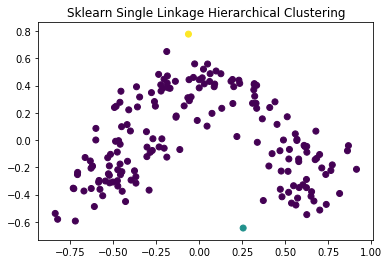

In [7]:
plt.scatter(data[:,0], data[:,1], c=single_labels)
plt.title('Sklearn Single Linkage Hierarchical Clustering')
plt.show()

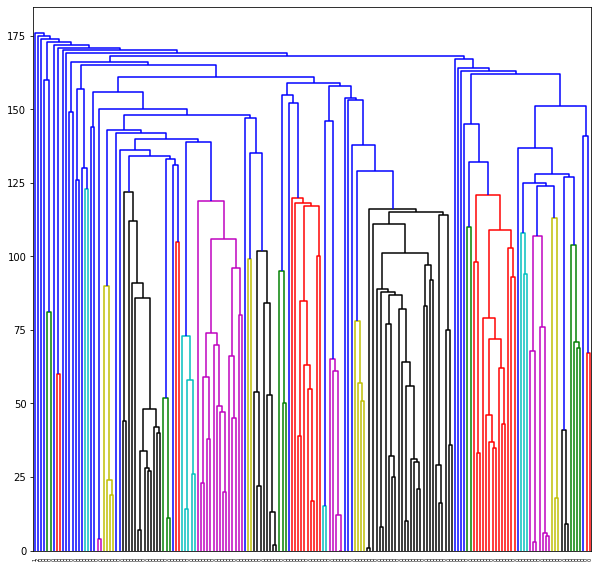

In [24]:
plt.figure(figsize=(10,10))

# Hierarchical Clustering의 자식 노드
children = single_clustering.children_

# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])

# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(10, children.shape[0]+10)

# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# 덴드로그램을 그립니다.
dendrogram(linkage_matrix, p = N, labels = single_labels, 
           show_contracted=True, no_labels = False )
plt.show()

In [22]:
linkage_matrix

array([[ 47.,  51.,   0.,  10.],
       [ 10.,  52.,   1.,  11.],
       [ 90.,  91.,   2.,  12.],
       [ 83., 140.,   3.,  13.],
       [ 65.,  78.,   4.,  14.],
       [132., 142.,   5.,  15.],
       [162., 183.,   6.,  16.],
       [100., 104.,   7.,  17.],
       [ 30.,  55.,   8.,  18.],
       [138., 160.,   9.,  19.],
       [ 46.,  56.,  10.,  20.],
       [ 66.,  98.,  11.,  21.],
       [  9., 178.,  12.,  22.],
       [105., 180.,  13.,  23.],
       [ 64.,  86.,  14.,  24.],
       [  0.,  42.,  15.,  25.],
       [  1.,  44.,  16.,  26.],
       [ 27.,  36.,  17.,  27.],
       [145., 163.,  18.,  28.],
       [ 76., 102.,  19.,  29.],
       [101., 119.,  20.,  30.],
       [  8.,  39.,  21.,  31.],
       [107., 112.,  22.,  32.],
       [114., 117.,  23.,  33.],
       [126., 197.,  24.,  34.],
       [ 12.,  57.,  25.,  35.],
       [ 59.,  75.,  26.,  36.],
       [ 84.,  99.,  27.,  37.],
       [120., 205.,  28.,  38.],
       [ 35., 194.,  29.,  39.],
       [  

### 2. Complete Linkage - 두 클러스터 내의 가장 먼 점 사이의 거리
linkage를 'complete'로 설정하고, 클러스터의 수는 3개로 설정합니다.

In [9]:
complete_clustering = AgglomerativeClustering(linkage='complete', 
                                              n_clusters=3).fit(data)
complete_labels = complete_clustering.labels_

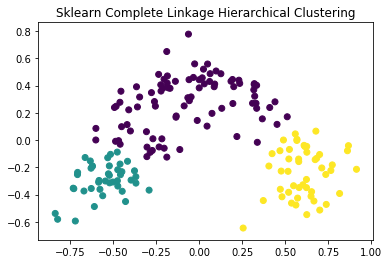

In [10]:
plt.scatter(data[:,0], data[:,1], c=complete_labels)
plt.title('Sklearn Complete Linkage Hierarchical Clustering')
plt.show()

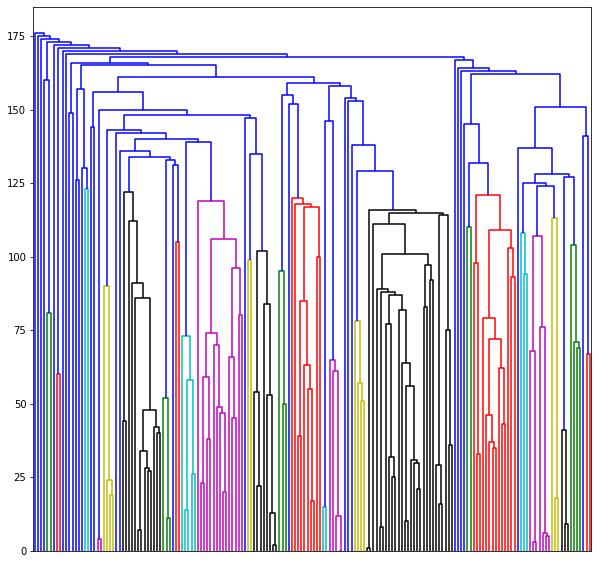

In [11]:
plt.figure(figsize=(10,10))

# Hierarchical Clustering의 자식 노드
children = single_clustering.children_

# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])

# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(2, children.shape[0]+2)

# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# 덴드로그램을 그립니다.
dendrogram(linkage_matrix, p = N, labels = single_labels, 
           show_contracted=True, no_labels = True, )
plt.show()

### 3.  Average Linkage - 두 클러스터 내의 모든 점 사이의 평균 거리
linkage를 'average'로 설정하고, 클러스터의 수는 3개로 설정합니다.

In [12]:
average_clustering = AgglomerativeClustering(linkage='average', 
                                              n_clusters=3).fit(data)
average_labels = average_clustering.labels_

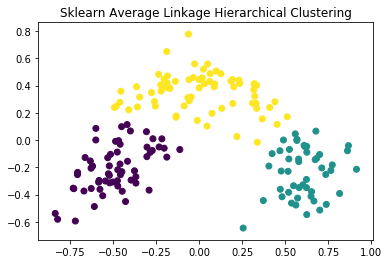

In [13]:
plt.scatter(data[:,0], data[:,1], c=average_labels)
plt.title('Sklearn Average Linkage Hierarchical Clustering')
plt.show()

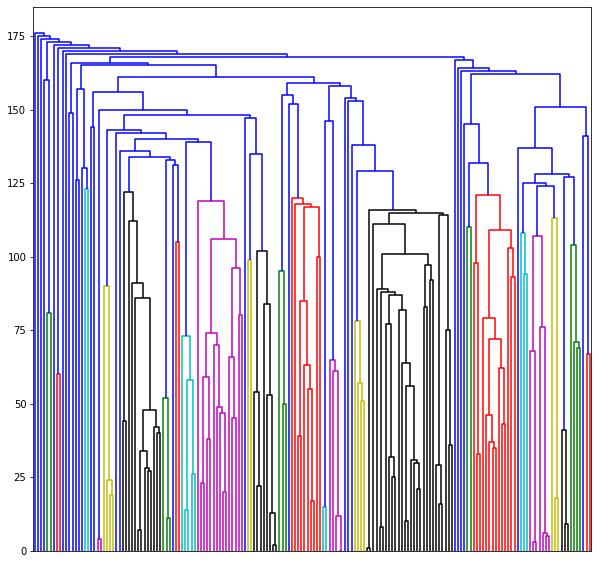

In [14]:
plt.figure(figsize=(10,10))

# Hierarchical Clustering의 자식 노드
children = single_clustering.children_

# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])

# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(2, children.shape[0]+2)

# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# 덴드로그램을 그립니다.
dendrogram(linkage_matrix, p = N, labels = single_labels, 
           show_contracted=True, no_labels = True, )
plt.show()

## 4. 클러스터링 결과 비교하기

1. Single Linkage
    + 두 클러스터 내의 가장 가까운 점을 기준으로 클러스터를 합치기 클러스터 사이의 노이즈에 매우 민감한 특성과 구 형태가 아닌 데이터에 대해 클러스터를 잘 형성한다는 특성이 있습니다.
    + wine 데이터는 모든 데이터가 연결되어 있는 듯한 분포를 가지고 있기 때문에, 각 클러스터의 경계가 모호한 노이즈가 많은 형태를 띠고 있습니다. <br>Single Linkage가 구 형태가 아닌 데이터에 대해 클러스터를 잘 형성한다는 특성이 있지만, 이러한 데이터의 경우 Single Linkage 방법을 사용하면 좋은 클러스터를 생성하기 어렵습니다.

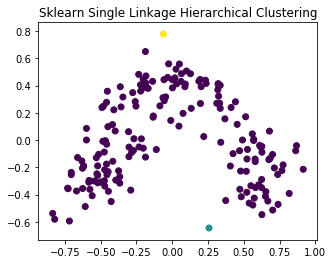

In [15]:
plt.figure(figsize=(5,4))

plt.scatter(data[:,0], data[:,1], c=single_labels)
plt.title('Sklearn Single Linkage Hierarchical Clustering')
plt.show()

2. Complete Linkage
    + 두 클러스터 내에 가장 먼 점을 기준으로 클러스터를 합치기 때문에 클러스터 사이의 노이즈와 이상치에 민감하지 않은 특성이 있습니다.
    + 노이즈에 민감하지 않다는 특성을 가진 Complete Linkage가 좋은 성능을 보여주었습니다. 
3. Average Linkage
    + Single Linkage와 Complete Linkage의 중간쯤에 위치한 Average Linkage가 가장 정답에 가까운 클러스터를 형성한 것을 확인할 수 있습니다. 

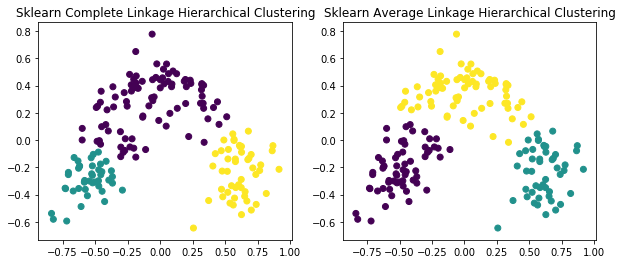

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c=complete_labels)
plt.title('Sklearn Complete Linkage Hierarchical Clustering')

plt.subplot(1, 2, 2)
plt.scatter(data[:,0], data[:,1], c=average_labels)
plt.title('Sklearn Average Linkage Hierarchical Clustering')
plt.show()

### Reference

- SKlearn PCA - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Sklearn AgglomerativeClustering - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
